In [106]:
import gdown
import shutil
from model import Generator
from torch import optim
from torch.nn import functional as F
import os
from torchvision import transforms
from PIL import Image
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])


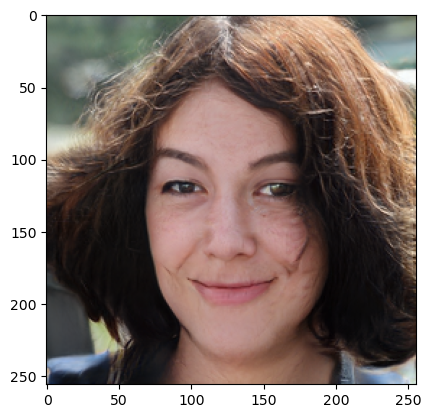

In [107]:
# !python test.py

# set torch random seed

np.random.seed(10)

resolution=256
weight_file="checkpoint/550000.pt"
g_ema = Generator(resolution, 512, 8, channel_multiplier=2).to(device)
# Load the checkpoint weights
checkpoint = torch.load(weight_file)
g_ema.load_state_dict(checkpoint["g_ema"],strict=False)
g_ema.eval()
for i in g_ema.parameters():
  i.requires_grad=False
random_latents = torch.tensor(np.random.randn(1, 512).astype(np.float32)).to(device)
# print(random_latents.shape)
images,_ = g_ema([random_latents],4096)
images = (images+1) / 2
print(images.shape)
plt.imshow(images[0].permute(1,2,0).detach().cpu().numpy())
plt.show(block=False)

In [92]:
# import discriminator from models.stylegan_layers
from model import Discriminator
from torch import nn
from torch.nn import functional as F

diss_weight = checkpoint['d']
d_basic = Discriminator(size=resolution, channel_multiplier=2).to(device)
d_basic.load_state_dict(diss_weight)
d_basic.eval()

class discri_loss(nn.Module):

    def __init__(self,model):
        super(discri_loss, self).__init__()
        self.model = model
        chs =[3,7]

        self.slice1 = torch.nn.Sequential(*list(self.model.convs)[:chs[0]])
        self.slice2 = torch.nn.Sequential(*list(self.model.convs)[chs[0]:chs[1]])

    def forward(self,imp1,imp2,normalize=False):
        # print(imp1.shape)
        # print(imp2.shape)
        if normalize:
            imp1 = 2 * imp1  - 1
            imp2 = 2 * imp2  - 1
        loss = 0
        imp1 = self.slice1(imp1)
        imp2 = self.slice1(imp2)
        loss += F.mse_loss(F.normalize(imp1),F.normalize(imp2))
        imp1 = self.slice2(imp1)
        imp2 = self.slice2(imp2)
        loss += F.mse_loss(F.normalize(imp1),F.normalize(imp2))
        # loss += F.mse_loss(imp1,imp2)

        # print(imp1.shape)
        # print(imp2.shape)
        return loss

        

In [93]:
from lpips import PerceptualLoss

diss_model_loss2 = discri_loss(d_basic).to(device)
percept_loss = PerceptualLoss(model="net-lin", net="vgg", use_gpu=device).to(device)

Setting up Perceptual loss...


/home/kaushikk/miniconda3/envs/ganasprior/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/kaushikk/miniconda3/envs/ganasprior/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/kaushikk/AIP/GANasPrior3/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


#### Analysis of Discriminator with courrupted images

In [94]:
print(d_basic(images*2-1).detach().cpu().numpy().flatten()[0])
print(diss_model_loss2(images*2-1,images*2-1).detach().cpu().numpy().flatten()[0])
print(percept_loss(images*2-1,images*2-1).detach().cpu().numpy().flatten()[0])

-2.0387464
0.0
0.0


/home/kaushikk/AIP/GANasPrior3/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


##### 1. Gaussian Noise

Text(0.5, 1.0, 'Pepper Noise')

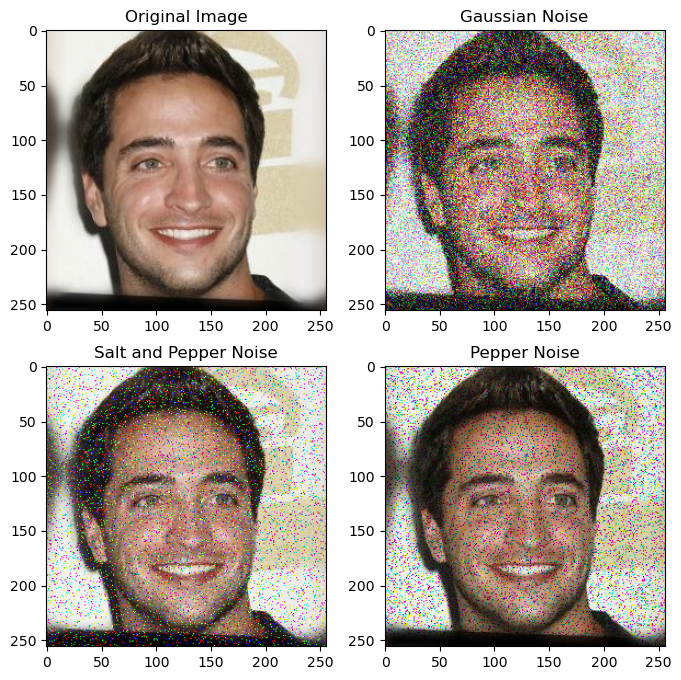

In [116]:
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import skimage

def add_gaussian_noise(img, mean=0, var=0.1,seed=1):
    if isinstance(img,Image.Image):
        img = np.array(img)/255
    noisey_img = skimage.util.random_noise(img, mode='gaussian',mean=mean,var=var,seed=1, clip=True)
    return noisey_img

def add_salt_pepper_noise(img, amount=0.1,seed=1):
    if isinstance(img,Image.Image):
        img = np.array(img)/255
    noisey_img = skimage.util.random_noise(img, mode='s&p',amount=amount,seed=seed, clip=True)
    return noisey_img

def add_pepper_noise(img, amount=0.1,seed=1):
    if isinstance(img,Image.Image):
        img = np.array(img)/255
    noisey_img = skimage.util.random_noise(img, mode='pepper',amount=amount,seed=seed, clip=True)
    return noisey_img

img = cv2.imread("./output/imgs256/10021.jpg")/255
# image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
drange = [-1,1]
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax = ax.flatten()
ax[0].imshow(img[...,::-1])
ax[0].set_title("Original Image")
ax[1].imshow(add_gaussian_noise(img)[...,::-1])
ax[1].set_title("Gaussian Noise")
ax[2].imshow(add_salt_pepper_noise(img)[...,::-1])
ax[2].set_title("Salt and Pepper Noise")
ax[3].imshow(add_pepper_noise(img)[...,::-1])
ax[3].set_title("Pepper Noise")

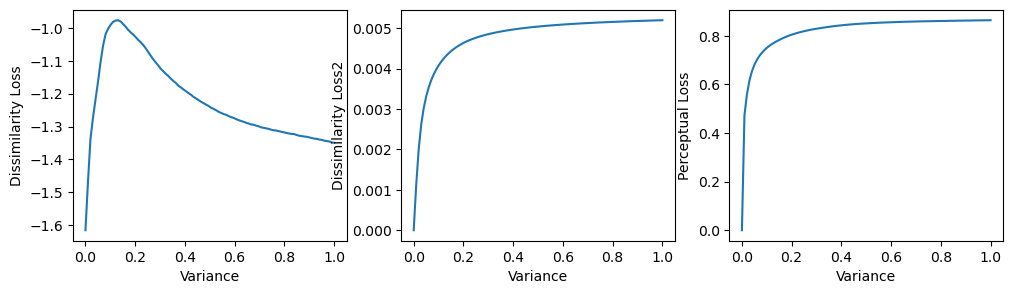

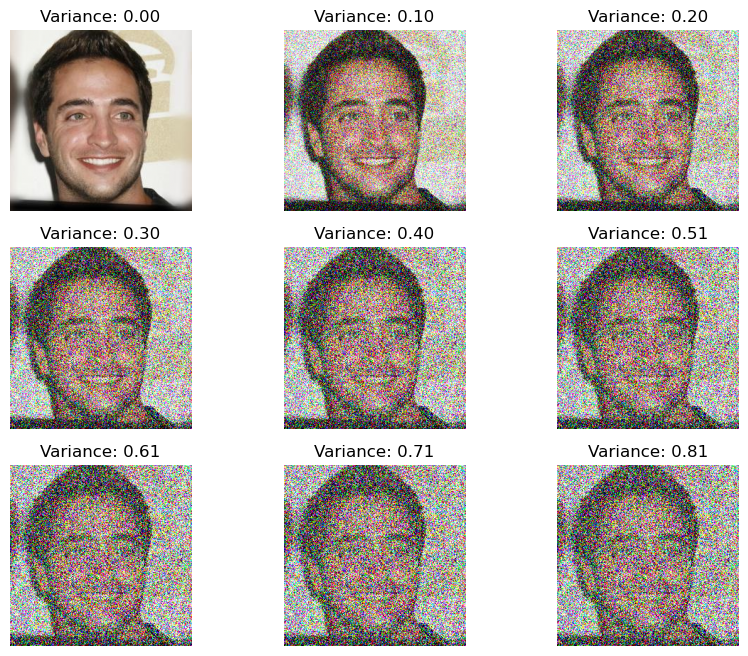

In [117]:
vars = np.linspace(0,1,100)
diss_loss = []
diss_loss2 = []
percept_list = []
sample_imgs =[]
img = cv2.imread("./output/imgs256/10021.jpg")/255
ref_tensor = torch.tensor(img,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device) *2 -1
for idx,var in enumerate(vars):
    noisey_img=add_gaussian_noise(img, var=var)
    if idx % 10 == 0:
        sample_imgs.append(noisey_img)
    noisey_img = noisey_img.astype(np.float32) 
    noisey_img = noisey_img * (drange[1] - drange[0]) + drange[0]
    noisey_img = torch.tensor(noisey_img).permute(2,0,1).unsqueeze(0).to(device) 
    diss_loss.append(d_basic(noisey_img).detach().cpu().numpy().flatten()[0])
    diss_loss2.append(diss_model_loss2(noisey_img,ref_tensor).detach().cpu().numpy().flatten()[0])
    percept_list.append(percept_loss(noisey_img,ref_tensor).detach().cpu().numpy().flatten()[0])
fig ,ax = plt.subplots(1,3,figsize=(12,3))
# ax[0].set_title("Dissimilarity Loss vs Gaussian Noise Variance",fontsize=10)
ax[0].set_xlabel("Variance")
ax[0].set_ylabel("Dissimilarity Loss")
ax[0].plot(vars, diss_loss)
# ax[1].set_title("Dissimilarity Loss2 vs Gaussian Noise Variance")
ax[1].set_xlabel("Variance")
ax[1].set_ylabel("Dissimilarity Loss2")
ax[1].plot(vars, diss_loss2)
# ax[2].set_title("Perceptual Loss vs Gaussian Noise Variance")
ax[2].set_xlabel("Variance")
ax[2].set_ylabel("Perceptual Loss")
ax[2].plot(vars, percept_list)
plt.show()

row,col =3,3
fig, ax = plt.subplots(row,col, figsize=(10,8))
ax = ax.flatten()
for idx, img_ in enumerate(sample_imgs):
    ax[idx].imshow(img_[...,::-1])
    ax[idx].set_title("Variance: {:.2f}".format(vars[idx*10]))
    ax[idx].axis('off')
    if idx == row*col-1:
        break

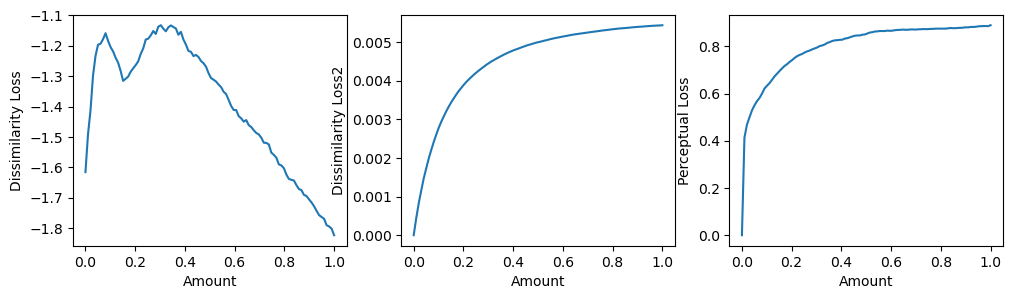

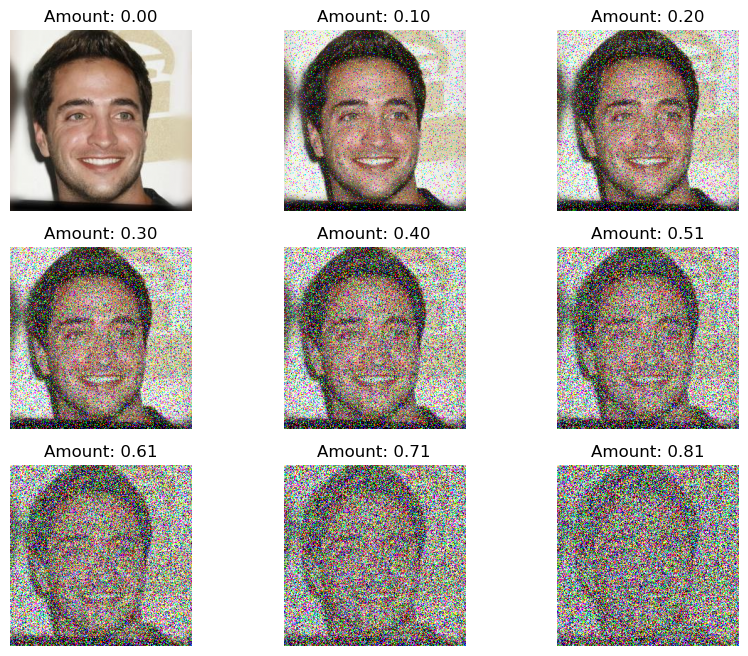

In [120]:
amounts = np.linspace(0,1,100)
diss_loss = []
diss_loss2 = []
percept_list = []
img = cv2.imread("./output/imgs256/10021.jpg")/255
ref_tensor = torch.tensor(img,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device) *2 -1
sample_imgs =[]
for idx,amount in enumerate(amounts):
    noisey_img=add_salt_pepper_noise(img, amount=amount)
    if idx % 10 == 0:
        sample_imgs.append(noisey_img)
    noisey_img = noisey_img.astype(np.float32) 
    noisey_img = noisey_img * (drange[1] - drange[0]) + drange[0]
    noisey_img = torch.tensor(noisey_img).permute(2,0,1).unsqueeze(0).to(device) 
    diss_loss.append(d_basic(noisey_img).detach().cpu().numpy().flatten()[0])
    diss_loss2.append(diss_model_loss2(noisey_img,ref_tensor).detach().cpu().numpy().flatten()[0])
    percept_list.append(percept_loss(noisey_img,ref_tensor).detach().cpu().numpy().flatten()[0])
fig ,ax = plt.subplots(1,3,figsize=(12,3),sharex=True)
# ax[0].set_title("Dissimilarity Loss vs Gaussian Noise Variance",fontsize=10)
ax[0].set_xlabel("Amount")
ax[0].set_ylabel("Dissimilarity Loss")
ax[0].plot(amounts, diss_loss)
# ax[1].set_title("Dissimilarity Loss2 vs Gaussian Noise Variance")
ax[1].set_xlabel("Amount")
ax[1].set_ylabel("Dissimilarity Loss2")
ax[1].plot(amounts, diss_loss2)
# ax[2].set_title("Perceptual Loss vs Gaussian Noise Variance")
ax[2].set_xlabel("Amount")
ax[2].set_ylabel("Perceptual Loss")
ax[2].plot(amounts, percept_list)
plt.show()


row,col =3,3
fig, ax = plt.subplots(row,col, figsize=(10,8))
ax = ax.flatten()
for idx, img_ in enumerate(sample_imgs):
    ax[idx].imshow(img_[...,::-1])
    ax[idx].set_title("Amount: {:.2f}".format(amounts[idx*10]))
    ax[idx].axis('off')
    if idx == row*col-1:
        break

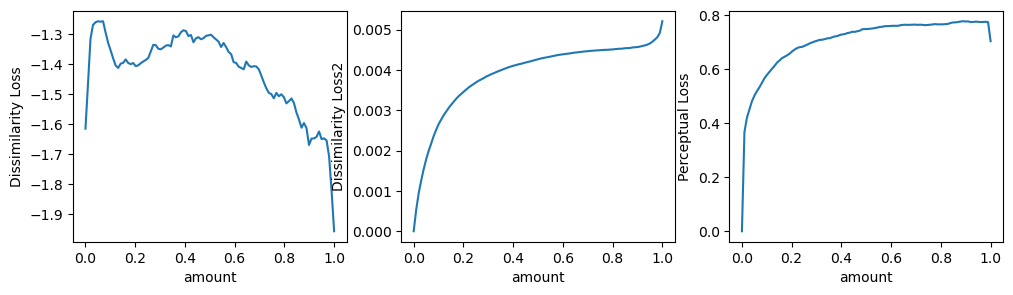

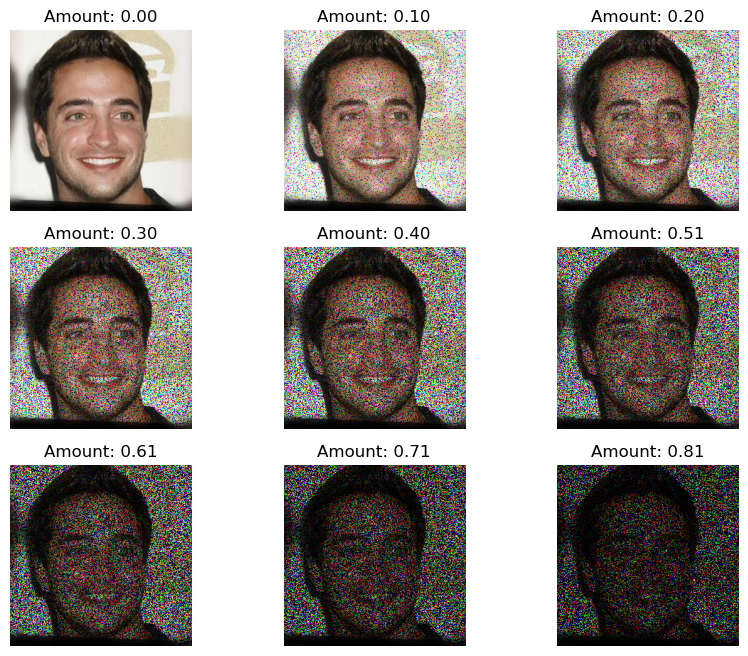

In [121]:
amounts = np.linspace(0,1,100)
diss_loss = []
diss_loss2 = []
percept_list = []
sample_imgs =[]
img = cv2.imread("./output/imgs256/10021.jpg")/255
ref_tensor = torch.tensor(img,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device) *2 -1
for idx,amount in enumerate(amounts):
    noisey_img=add_pepper_noise(img, amount=amount)
    if idx % 10 == 0:
        sample_imgs.append(noisey_img)
    noisey_img = noisey_img.astype(np.float32) 
    noisey_img = noisey_img * (drange[1] - drange[0]) + drange[0]
    noisey_img = torch.tensor(noisey_img).permute(2,0,1).unsqueeze(0).to(device) 
    diss_loss.append(d_basic(noisey_img).detach().cpu().numpy().flatten()[0])
    diss_loss2.append(diss_model_loss2(noisey_img,ref_tensor).detach().cpu().numpy().flatten()[0])
    percept_list.append(percept_loss(noisey_img,ref_tensor).detach().cpu().numpy().flatten()[0])
fig ,ax = plt.subplots(1,3,figsize=(12,3))
# ax[0].set_title("Dissimilarity Loss vs Gaussian Noise Variance",fontsize=10)
ax[0].set_xlabel("amount")
ax[0].set_ylabel("Dissimilarity Loss")
ax[0].plot(amounts, diss_loss)
# ax[1].set_title("Dissimilarity Loss2 vs Gaussian Noise Variance")
ax[1].set_xlabel("amount")
ax[1].set_ylabel("Dissimilarity Loss2")
ax[1].plot(amounts, diss_loss2)
# ax[2].set_title("Perceptual Loss vs Gaussian Noise Variance")
ax[2].set_xlabel("amount")
ax[2].set_ylabel("Perceptual Loss")
ax[2].plot(amounts, percept_list)
plt.show()

row,col =3,3
fig, ax = plt.subplots(row,col, figsize=(10,8))
ax = ax.flatten()
for idx, img_ in enumerate(sample_imgs):
    ax[idx].imshow(img_[...,::-1])
    ax[idx].set_title("Amount: {:.2f}".format(amounts[idx*10]))
    ax[idx].axis('off')
    if idx == row*col-1:
        break

##### 2. Noise Image Jpeg comprasion artifact Analysis on discriminator

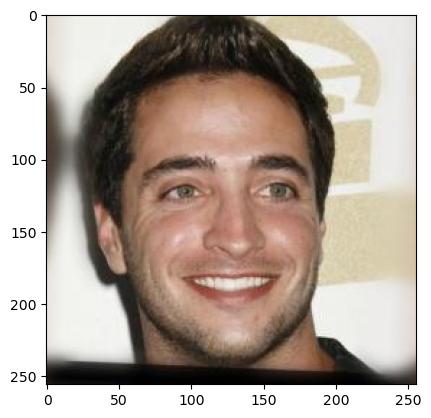

In [47]:
import cv2 

img = cv2.imread("./output/imgs256/10021.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB,)
plt.imshow(img[...,::-1])

In [113]:
cr_ratios = np.linspace(10,100,10)
diss_loss = []
diss_loss2 = []
percept_list = []
sample_imgs =[]
img = cv2.imread("./output/imgs256/10021.jpg")
ref_tensor = torch.tensor(img,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
for idx,cr_ratio in enumerate(cr_ratios):
    print(cr_ratio)
    encode_param = [cv2.IMWRITE_JPEG_QUALITY, int(cr_ratio)]
    result,enc_img = cv2.imencode('.jpg', img, encode_param)
    noisey_img = cv2.imdecode(enc_img, 1)
    sample_imgs.append(noisey_img)
    noisey_img = noisey_img.astype(np.float32) 
    noisey_img = noisey_img * (drange[1] - drange[0]) + drange[0]
    noisey_img = torch.tensor(noisey_img).permute(2,0,1).unsqueeze(0).to(device) 
    diss_loss.append(d_basic(noisey_img).detach().cpu().numpy().flatten()[0])
    diss_loss2.append(diss_model_loss2(noisey_img,ref_tensor).detach().cpu().numpy().flatten()[0])
    percept_list.append(percept_loss(noisey_img,ref_tensor).detach().cpu().numpy().flatten()[0])
fig ,ax = plt.subplots(1,3,figsize=(12,3))
# ax[0].set_title("Dissimilarity Loss vs Gaussian Noise Variance",fontsize=10)
ax[0].set_xlabel("Compresion Ratio")
ax[0].set_ylabel("Dissimilarity Loss")
ax[0].plot(cr_ratios, diss_loss)
# ax[1].set_title("Dissimilarity Loss2 vs Gaussian Noise Variance")
ax[1].set_xlabel("Compresion Ratio")
ax[1].set_ylabel("Dissimilarity Loss2")
ax[1].plot(cr_ratios, diss_loss2)
# ax[2].set_title("Perceptual Loss vs Gaussian Noise Variance")
ax[2].set_xlabel("Compresion Ratio")
ax[2].set_ylabel("Perceptual Loss")
ax[2].plot(cr_ratios, percept_list)
plt.show()

row,col =3,3
fig, ax = plt.subplots(row,col, figsize=(10,8))
ax = ax.flatten()
for idx, img_ in enumerate(sample_imgs):
    ax[idx].imshow(img_[...,::-1])
    ax[idx].set_title("Amount: {:.2f}".format(cr_ratios[idx]))
    ax[idx].axis('off')
    if idx == row*col-1:
        break


10.0
20.0
30.0
40.0
50.0
60.0
70.0


/home/kaushikk/AIP/GANasPrior3/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


80.0
90.0
100.0
